# Lab04 - Music sequences modelling with RNNs

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import pypianoroll

In [2]:
# Check if CUDA cores are available
if torch.cuda.is_available():
    useCuda = True
    device = torch.device('cuda')
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    useCuda = False
    device = torch.device('cpu')

print('I use cuda:',useCuda)

I use cuda: False


Now we will explore the functionalities of each component of the problem. For the complete training we will redefine everything from scratch, you can check it on the **Training Procedure** section.

## PyPianoRoll
[PyPianoRoll](https://salu133445.github.io/pypianoroll/index.html) is a python package for handling multi-track pianorolls. We will use it to handle midi files and convert them in numpy arrays. 
Each pitch is represented by a number. In particular, since every octave is composed of 12 different pitches, their beginnings (note $C$ or $Do$ ) correspond to a multiple of 12. For example, the zero of the axis corresponds to $C_{-2}$, the Middle $C$ (i.e. $C_4$ ) of the piano keyboard is represented by the number 72 and the highest pitch is defined by the number 127.

Let's consider a small multi-track midi file: Since in thìs exercise we will work with single tracks, we want to extract from it the lead melody and remove the other tracks.

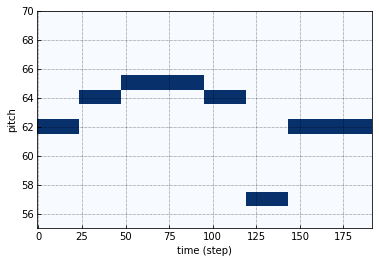

In [8]:
# Print a test Midi file
piano_test = pypianoroll.parse('multitrack_test.mid')
piano_test.tracks[1].plot(ytick='pitch')
plt.ylim(55,70)
plt.show()

## The MIDI Dataset
Before working on the model or on its training, let's explore the data. The MIDI dataset is taken from [piano-midi.de](http://www.piano-midi.de/midicoll.htm) and contains MIDI piano tracks of classical music reconstructed with a sequencer. This dataset was chosen because the time resolution of the files is not constant but it is a function of the track (so it is not measured in seconds).

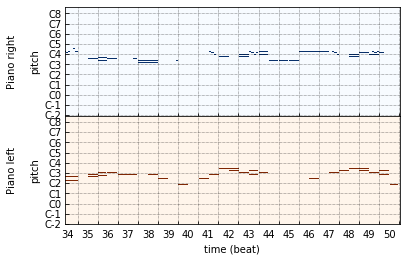

In [6]:
# Import one song from the dataset and plot a portion of it
song = pypianoroll.parse('piano-midi-de/mozart/mz_333_2.mid')
song = pypianoroll.binarize(song) # remove intensities and consider notes as bool
song.plot()
plt.xlim(800, 1200)
plt.show()

Since by default the whole spectrum is covered by 128 notes, we want to check if all of them are used. If it is not the case, we will clip this range to the used ones in order to reduce input and output size of the network.

In [7]:
# Find the lowest note and highest note of all the dataset
lowest = 127
highest = 0   # start from opposite values

import os
for composer in os.listdir('piano-midi-de'):
    for filename in os.listdir('piano-midi-de/'+composer):

        # Read midi file and get its lowest and highest note
        midi_song = pypianoroll.parse('piano-midi-de/'+composer+'/'+filename)
        low, high = midi_song.get_active_pitch_range()

        # Check if they are lower/higher than the previous
        if (low<lowest):   lowest = low
        if (high>highest): highest = high
    
print('\nLowest and highest notes are respectively',lowest,'and',highest)


Lowest and highest notes are respectively 21 and 107


The result of the cell above makes sense, since the keys of a grand piano cover the interval `[21,108]`,  so we will crop the pitch range to thiss interval. 

Moreover, since we will mainly focus on building good harmonies and chord progressions, the intensity of the midi notes will be simplyfied with a binary variable (on/off).

We will also reduce the time resolution of the midi: by sampling 1 timestep of the song every 6 we obtain a resolution of (1/16)th of the measure.

## Pre-processing
In python the midi acquisition and conversion is really slow, so it is helpful to store all the songs as numpy objects before building the dataset.

This is done by running the dedicated script, which executes also the preprocessing discussed in the cell above:

```
python numpy_pre-process_script.py
```

In addition to that we also built a Dataset and a Network to handle separately the tracks produced by the two hands playing the piano (hoping to improve the quality of the generatd samples). In this case, we have to run a different script:

```
python numpy_pre-process_script_two_hands.py
```

## Build the Dataset

The `Piano_Dataset` class build a dictrionary with all the songs in the dataset and a list of indexes to access to avery possible sample of length equal to `sample_length` that can be extracted from these song. These samples will be elaborated by the RNN, which will have to estimate the played notes in the timestep after the sample.

In order to increment the dataset size, we transpose all the available songs of $[-2,-1,0,+1,+2]$ semi-tones. This done by shifting the 'ones' of the song with the same number of rows (we obtain a dataset 5 times bigger than the original).

In [10]:
# Import dataset class from the file
from Dataset_class import Piano_Dataset, Piano_Dataset_two_hands

Using the `Piano_Dataset` class and `Dataloader` we build an object that produces batches of samples(can take few minutes):

#### For original model

In [11]:
# This works only after having generated the numpy dataset with 'pre-process_script.py'
dataset = Piano_Dataset('numpy_piano-midi-de', transpose=[-1,0,+1])  # 32 = 2 full measures
dataloader = data.DataLoader(dataset, batch_size=100, shuffle=True)
print('Number of samples extracted from the dataset:', len(dataset))

# Test the dataloader
for sample_batch, next_step_batch, num_notes_batch in dataloader:
    print('\nSample batch shape:                ',sample_batch.shape)
    print('Following note batch shape:        ',next_step_batch.shape)
    print('Number of played notes batch shape:',num_notes_batch.shape)
    break

Number of samples extracted from the dataset: 1685580

Sample batch shape:                 torch.Size([100, 32, 88])
Following note batch shape:         torch.Size([100, 88])
Number of played notes batch shape: torch.Size([100])


#### For two-hands model

In [11]:
# This works only after having generated the numpy dataset with 'pre-process_script.py'
dataset = Piano_Dataset_two_hands('numpy_piano-midi-de_two_hands', transpose=[-2,-1,0,+1,+2], encode_sparse_mat=True)  # 32 = 2 full measures
dataloader = data.DataLoader(dataset, batch_size=100, shuffle=True)
print('Number of samples extracted from the dataset:', len(dataset))

# Test the dataloader
for sample_batch, next_step_batch, num_notes_batch in dataloader:
    print('\nSample batch shape:                ',sample_batch.shape)
    print('Following note batch shape:        ',next_step_batch.shape)
    print('Number of played notes batch shape:',num_notes_batch.shape)
    break

Number of samples extracted from the dataset: 2755390

Sample batch shape:                 torch.Size([100, 2, 32, 88])
Following note batch shape:         torch.Size([100, 2, 88])
Number of played notes batch shape: torch.Size([100, 2])


### RNN Structure
#### For original model
The network that we are going to use is based on a LSTM layer that takes in input the 88 bool variables (keys of the piano) at each timestep. We wanted the network to be able to understand the temporal structure of the music sample and to give aprobability distribution of which piano notes should be played in the timestep following the sequence.

Moreover, we wanted also to understand how many notes should be played in that timestep, so we build a network with two outputs. Before the outputs layers we added two dense layers (one for each of them).

Since the Network structure will be used also for the generation of samples, we defined the `RNN_net` class, which contains the 'train_batch' method that handles the training cycle of the network using one batch in a separate file: 

In [9]:
from RNN_structure import RNN_net

Now we will do some small tests to check that the network is working correctly

In [229]:
### Few tests to check that the network is working ###

# Initialize network
hidden_units = 64
layers_num = 2
dropout_prob = 0.3
net = RNN_net(hidden_units, layers_num, dropout_prob)
net.to(device)

# Test the network output
out_piano, out_num_notes, rnn_state = net(sample_batch)
print(out_piano.shape)
print(out_num_notes.shape)
print(rnn_state[0].shape)
print(rnn_state[1].shape)

torch.Size([100, 32, 88])
torch.Size([100, 32, 1])
torch.Size([2, 100, 64])
torch.Size([2, 100, 64])


In [451]:
#%% Test network update for a single batch
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.00001)
loss_fn_piano = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1]*88)) 
loss_fn_notes = nn.MSELoss()          # pos weight ~= "# of 0" - "# of 1" for each note

print('Value of the 2 losses (piano and num_notes):\n')
print(net.train_batch(sample_batch, next_step_batch, num_notes_batch, 
                      loss_fn_piano, loss_fn_notes, optimizer, loss_coeff=5))

Value of the 2 losses (piano and num_notes):

(0.11420203745365143, 1.4018516540527344)


Here we print an output example of the network, explaining how to select a result given the output of the network:

We sample 1 notes from the following distribution:


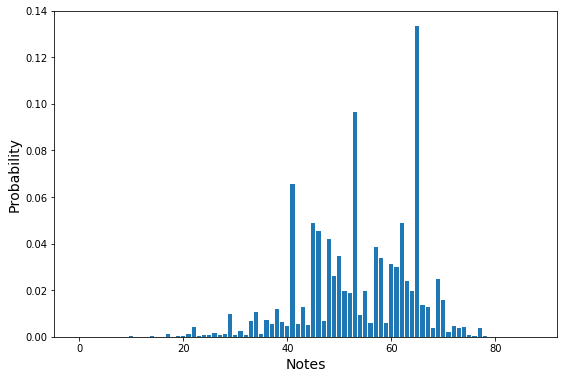

In [84]:
#out_piano, out_num_notes, rnn_state = net(sample_batch)
s = 1  # selected sample to analize

print('We sample', int(out_num_notes[s,-1].cpu().detach().numpy()),'notes from the following distribution:')
plt.figure(figsize=(9,6))

plt.bar(np.arange(88),F.softmax(out_piano[s,-1,:],dim=0).cpu().detach().numpy())
plt.xlabel("Notes", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.show()

#### For two-hands model
Here we test the advanced network considering the two hands separately, so we will have two distributions over the notes and we will sample different numbers of notes from both (notes played from right and left hands)

In [12]:
### Few tests to check that the new network is working ###

from RNN_structure import RNN_two_hands_net

# Initialize network
dropout_prob = 0.4
net = RNN_two_hands_net(dropout_prob)
net.to(device)

# Test the network output
print(sample_batch.shape)
out_R_piano, out_L_piano, out_R_num_notes, out_L_num_notes, rnn_state = net(sample_batch)
print(out_R_piano.shape)
print(out_L_piano.shape)
print(out_R_num_notes.shape)
print(out_L_num_notes.shape)
print(rnn_state[0].shape)
print(rnn_state[1].shape)

torch.Size([100, 2, 32, 88])
torch.Size([100, 32, 88])
torch.Size([100, 32, 1])
torch.Size([100, 32, 88])
torch.Size([100, 32, 1])
torch.Size([2, 100, 150])
torch.Size([2, 100, 150])


In [14]:
#%% Test network update for a single batch
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.00001)
positive_R_weights, positive_L_weights = dataset.get_pos_weights()
loss_fn_R_piano = nn.BCEWithLogitsLoss(torch.Tensor(positive_R_weights))
loss_fn_L_piano = nn.BCEWithLogitsLoss(torch.Tensor(positive_L_weights))
loss_fn_notes = nn.MSELoss()

print('Value of the 4 losses (piano and num_notes for R/L hands):\n')
print(net.train_batch(sample_batch, next_step_batch, num_notes_batch, loss_fn_R_piano, 
                      loss_fn_R_piano, loss_fn_notes, optimizer, loss_coeff=1))

Value of the 4 losses (piano and num_notes for R/L hands):

([52353.0390625, 50705.51171875], [2.9970827102661133, 3.294339418411255])


## Training Procedure
Now we will re-define the Dataset and the Network for the real training. First we will re-define their parameters and we will rebuild them from scratch.

#### For original model

In [5]:
########## DEFINE TRAINING PARAMETERS (ORIGINAL NETWORK) ##########

# Dataset (32 samples = 8 beats of music)
sample_length = 32
tunes = [-2,-1,0,+1,+2]
batch_size = 100

# Network
hidden_units = 128
layers_num = 2
dropout_prob = 0.4
loss_coeff = 1.2           # loss = coeff*loss_piano + loss_notes
#dense_piano_units = 100   # these are the default values
#dense_notes_units = 10

# Training
lr = 0.001
weight_decay = 0.00001
max_epochs = 5

# compute mean losses every n batches
batches_for_mean = 2000
print_mean_losses = True

###################################################################




# Import Dataset and Network class from file (if not already imported)
from Dataset_class import Piano_Dataset
from RNN_structure import RNN_net

# Re-build the Dataset, the Dataloader and the Network
dataset = Piano_Dataset('numpy_piano-midi-de', sample_length=sample_length, transpose=tunes)
dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
net = RNN_net(hidden_units, layers_num, dropout_prob)
net.to(device)

# Define Optimizer and Loss functions
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
positive_weights = dataset.get_pos_weights()
loss_fn_piano = nn.BCEWithLogitsLoss(torch.Tensor(positive_weights))
loss_fn_notes = nn.MSELoss()

# Prepare empty lists for storing losses
all_piano_losses = np.array([])
all_notes_losses = np.array([])
all_composed_losses = np.array([])


########## START TRAINING ##########

for epoch in range(max_epochs):
    
    print('\n###################')
    print('##### EPOCH', epoch+1, '#####')
    print('###################')
    batch_counter = 0
    mean_piano_loss = 0
    mean_notes_loss = 0
    
    # Iterate batches
    for sample_batch, next_step_batch, num_notes_batch in dataloader:
        
        # Update batch counter
        batch_counter = batch_counter + 1
            
        # Update network
        batch_piano_loss, batch_notes_loss = net.train_batch(sample_batch, next_step_batch, num_notes_batch, 
                                                             loss_fn_piano, loss_fn_notes, optimizer, loss_coeff)
        
        # Update mean losses
        mean_piano_loss += batch_piano_loss/batches_for_mean
        mean_notes_loss += batch_notes_loss/batches_for_mean
        
        # Fill arrays with mean batch losses
        if (batch_counter % batches_for_mean == 0):
            mean_composed_loss = loss_coeff*mean_piano_loss + mean_notes_loss
            all_piano_losses = np.append(all_piano_losses, mean_piano_loss)
            all_notes_losses = np.append(all_notes_losses, mean_notes_loss)
            all_composed_losses = np.append(all_composed_losses, mean_composed_loss)
            
            # If flag is True, print means
            if print_mean_losses:
                print('\n\tMean piano loss:     ', mean_piano_loss)
                print('\tMean num_notes loss: ', mean_notes_loss)
                print('\tMean composed loss:  ', mean_composed_loss)
                
            # Reset the counter and means before computing losses for next 100 means
            batch_counter = 0
            mean_piano_loss = 0
            mean_notes_loss = 0


# After training, Save the model
torch.save(net.state_dict(), 'trained_models/first_net.pth') 

# Save mean losses after training
np.save('trained_models/mean_piano_losses.npy', all_piano_losses)
np.save('trained_models/mean_notes_losses.npy', all_notes_losses)
np.save('trained_models/mean_composed_losses.npy', all_composed_losses)



###################
##### EPOCH 1 #####
###################

	Mean piano loss:      82.79915348875525
	Mean num_notes loss:  3.0559777361750604
	Mean composed loss:   102.41496192268137

	Mean piano loss:      5.356057634830488
	Mean num_notes loss:  3.006315757036207
	Mean composed loss:   9.433584918832793

	Mean piano loss:      5.5254892687797525
	Mean num_notes loss:  3.010354397714137
	Mean composed loss:   9.64094152024984

	Mean piano loss:      5.316745185017584
	Mean num_notes loss:  2.172387069225312
	Mean composed loss:   8.552481291246412

	Mean piano loss:      4.480738683104525
	Mean num_notes loss:  1.59010354530811
	Mean composed loss:   6.966989965033539

	Mean piano loss:      4.551521142601957
	Mean num_notes loss:  1.4673127682507023
	Mean composed loss:   6.92913813937305

	Mean piano loss:      4.756486617445936
	Mean num_notes loss:  1.4355281909108175
	Mean composed loss:   7.14331213184594

	Mean piano loss:      6.117321962237362
	Mean num_notes loss:  1.391


	Mean piano loss:      2.8474865204095847
	Mean num_notes loss:  1.145029410302637
	Mean composed loss:   4.562013234794138


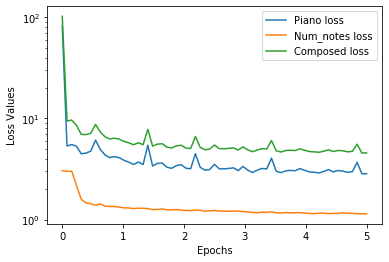

In [94]:
# Plot losses (load them from files if they are not in memory)
all_piano_losses = np.load('trained_models/mean_piano_losses.npy')
all_notes_losses = np.load('trained_models/mean_notes_losses.npy')
all_composed_losses = np.load('trained_models/mean_composed_losses.npy')

x_points = np.arange(len(all_piano_losses))*5/(len(all_piano_losses)-1)
plt.plot(x_points, all_piano_losses, label='Piano loss')
plt.plot(x_points, all_notes_losses, label='Num_notes loss')
plt.plot(x_points, all_composed_losses, label='Composed loss')

plt.xlabel('Epochs')
plt.ylabel('Loss Values')
plt.yscale('log')
plt.legend()
plt.show()

#### For two-hands model

In [3]:
########## DEFINE TRAINING PARAMETERS (2 HANDS NETWORK) ##########

# Dataset (32 samples = 8 beats of music)
sample_length = 32
tunes = [-2,-1,0,+1,+2,+3]
batch_size = 100

# Network
dropout_prob = 0.5
loss_coeff = 1.2           # loss = coeff*loss_piano + loss_notes
#lstm_hidden_units = 200   # these are kept equal to default values
#lstm_layers_num = 3
#dense_hands_units = 150
#dense_piano_units = 100
#dense_notes_units = 10

# Training
lr = 0.001
weight_decay = 0.00001
max_epochs = 4

# compute mean losses every n batches
batches_for_mean = 2000
print_mean_losses = True

#################################################################




# Import Dataset and Network class from file (if not already imported)
from Dataset_class import Piano_Dataset_two_hands
from RNN_structure import RNN_two_hands_net

# Re-build the Dataset, the Dataloader and the Network
dataset = Piano_Dataset_two_hands('numpy_piano-midi-de_two_hands', sample_length=sample_length, transpose=tunes)
dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
net = RNN_two_hands_net(dropout_prob)
net.to(device)

print('Finished building Network and Dataloader\n')

# Define Optimizer and Loss functions
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
positive_R_weights, positive_L_weights = dataset.get_pos_weights()
loss_fn_R_piano = nn.BCEWithLogitsLoss(torch.Tensor(positive_R_weights))
loss_fn_L_piano = nn.BCEWithLogitsLoss(torch.Tensor(positive_L_weights))
loss_fn_notes = nn.MSELoss()

# Prepare empty lists for storing losses
all_R_piano_losses = np.array([])
all_R_notes_losses = np.array([])
all_L_piano_losses = np.array([])
all_L_notes_losses = np.array([])
all_composed_losses = np.array([])


########## START TRAINING ##########

for epoch in range(max_epochs):
    
    print('\n###################')
    print('##### EPOCH', epoch+1, '#####')
    print('###################')
    batch_counter = 0
    mean_R_piano_loss = 0
    mean_R_notes_loss = 0
    mean_L_piano_loss = 0
    mean_L_notes_loss = 0
    
    # Iterate batches
    for sample_batch, next_step_batch, num_notes_batch in dataloader:
        
        # Update batch counter
        batch_counter = batch_counter + 1
            
        # Update network
        batch_piano_loss, batch_notes_loss = net.train_batch(sample_batch, next_step_batch, num_notes_batch, 
                                                             loss_fn_R_piano, loss_fn_L_piano, loss_fn_notes,
                                                             optimizer, loss_coeff=loss_coeff)
        
        # Update mean losses
        mean_R_piano_loss += batch_piano_loss[0]/batches_for_mean
        mean_R_notes_loss += batch_notes_loss[0]/batches_for_mean
        mean_L_piano_loss += batch_piano_loss[1]/batches_for_mean
        mean_L_notes_loss += batch_notes_loss[1]/batches_for_mean

        # Fill arrays with mean batch losses
        if (batch_counter % batches_for_mean == 0):
            
            mean_composed_loss = loss_coeff*(mean_R_piano_loss+mean_L_piano_loss) + mean_R_notes_loss+mean_L_notes_loss
                
            all_R_piano_losses = np.append(all_R_piano_losses, mean_R_piano_loss)
            all_L_piano_losses = np.append(all_L_piano_losses, mean_L_piano_loss)
            all_R_notes_losses = np.append(all_R_notes_losses, mean_R_notes_loss)
            all_L_notes_losses = np.append(all_L_notes_losses, mean_L_notes_loss)
            all_composed_losses = np.append(all_composed_losses, mean_composed_loss)
            
            # If flag is True, print means
            if print_mean_losses:
                print('\n\tMean R piano loss:     ', mean_R_piano_loss)
                print('\tMean L piano loss:     ', mean_L_piano_loss)
                print('\tMean R num_notes loss: ', mean_R_notes_loss)
                print('\tMean L num_notes loss: ', mean_L_notes_loss)
                print('\tMean composed loss:  ', mean_composed_loss)
                
            # Reset the counter and means before computing losses for next 100 means
            batch_counter = 0
            mean_R_piano_loss = 0
            mean_R_notes_loss = 0
            mean_L_piano_loss = 0
            mean_L_notes_loss = 0


# After training, Save the model
torch.save(net.state_dict(), 'trained_models/two_hands_net.pth') 

# Save mean losses after training
np.save('trained_models/mean_R_piano_losses.npy', all_R_piano_losses)
np.save('trained_models/mean_R_notes_losses.npy', all_R_notes_losses)
np.save('trained_models/mean_L_piano_losses.npy', all_L_piano_losses)
np.save('trained_models/mean_L_notes_losses.npy', all_L_notes_losses)
np.save('trained_models/mean_composed_losses.npy', all_composed_losses)


Finished building Network and Dataloader


###################
##### EPOCH 1 #####
###################

	Mean R piano loss:      261.1598148390066
	Mean L piano loss:      471.4227172683475
	Mean R num_notes loss:  1.1932733290195476
	Mean L num_notes loss:  1.1127864017486566
	Mean composed loss:   881.4050982595932

	Mean R piano loss:      7.217050008296961
	Mean L piano loss:      6.38721092450619
	Mean R num_notes loss:  1.1736437509953979
	Mean L num_notes loss:  1.0927185959219954
	Mean composed loss:   18.591475466281175

	Mean R piano loss:      7.5363027181625535
	Mean L piano loss:      7.083164053440105
	Mean R num_notes loss:  1.1781296487450585
	Mean L num_notes loss:  1.093047526419162
	Mean composed loss:   19.814537301087412

	Mean R piano loss:      8.138887838125223
	Mean L piano loss:      6.277875800967208
	Mean R num_notes loss:  1.1782598986327657
	Mean L num_notes loss:  1.09666713309288
	Mean composed loss:   19.575043398636563

	Mean R piano loss:      7.93326


	Mean R piano loss:      5.432088198781005
	Mean L piano loss:      5.011083999276159
	Mean R num_notes loss:  0.8289352073669417
	Mean L num_notes loss:  0.9221139788329596
	Mean composed loss:   14.282855823868497

	Mean R piano loss:      5.444569019556058
	Mean L piano loss:      5.150762073218817
	Mean R num_notes loss:  0.8111400221288194
	Mean L num_notes loss:  0.9155347412228575
	Mean composed loss:   14.441072074681527

	Mean R piano loss:      6.6322437109351124
	Mean L piano loss:      5.070730283617977
	Mean R num_notes loss:  0.8318503419756879
	Mean L num_notes loss:  0.9139650471806537
	Mean composed loss:   15.789384182620049

	Mean R piano loss:      5.584235275626188
	Mean L piano loss:      7.3548500280380145
	Mean R num_notes loss:  0.8222616131156669
	Mean L num_notes loss:  0.9179973661899551
	Mean composed loss:   17.267161343702664

	Mean R piano loss:      5.361064492344841
	Mean L piano loss:      5.466069777131086
	Mean R num_notes loss:  0.8116564424186935

ValueError: x and y must have same first dimension, but have shapes (65,) and (95,)

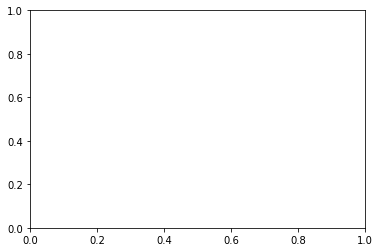

In [3]:
all_R_piano_losses = np.load('trained_models/mean_R_piano_losses.npy')
all_L_piano_losses = np.load('trained_models/mean_L_piano_losses.npy')
all_R_notes_losses = np.load('trained_models/mean_R_notes_losses.npy')
all_L_notes_losses = np.load('trained_models/mean_L_notes_losses.npy')
all_composed_losses = np.load('trained_models/mean_composed_losses.npy')

x_points = np.arange(len(all_composed_losses))*4/(len(all_composed_losses)-1)
plt.plot(x_points, all_R_piano_losses)
plt.plot(x_points, all_L_piano_losses)
plt.plot(x_points, all_R_notes_losses)
plt.plot(x_points, all_L_notes_losses)
plt.plot(x_points, all_composed_losses)
plt.yscale('log')
plt.show()

In [82]:
net = torch.load('trained_models/two_hands_net.pth')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.